# *Predicción de Calidad del Aire Para Deportistas*

**Por: Juan Guillermo Escobar Baez**

**En este proyecto, se trabajará sobre un dataset obtenido de Kaggle, que tiene datos monitoreados sobre la calidad del aire en la ciudad de Pune, India; a partir de este, se realizará (por medio de modelos de Machine Learning) una predicción del AQI, que permitirá al usuario (con la introducción de datos nuevos) la toma de decisiones.**

#1. Importación del dataset desde Kaggle

* Desde Kaggle (plataforma de datos abiertos), se importa un dataset, que contiene parámetros para determinar la calidad del aire (PM2.5, PM10, etcétera).

* Se utiliza la librería de Kagglehub para realizar esto

* Para crear el dataframe Pandas, se utiliza Pandas (pd) para tratar los datos.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Download latest version
path = kagglehub.dataset_download("pranavraizada/pune-air-quality-index-dataset")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/2024_hourly_data.csv")
df.head()

100%|██████████| 104k/104k [00:00<00:00, 47.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pranavraizada/pune-air-quality-index-dataset/versions/2


,Date,Time,CO,NH3,NO2,OZONE,PM10,PM2.5,SO2
0,2023-12-31,01:00:00,59.0,6.0,34.0,0.0,191.0,211.0,3.0
1,2023-12-31,02:00:00,62.0,6.0,33.0,1.0,185.0,225.0,4.0
2,2023-12-31,03:00:00,50.0,6.0,30.0,0.0,182.0,240.0,3.0
3,2023-12-31,04:00:00,52.0,5.0,27.0,0.0,176.0,247.0,3.0
4,2023-12-31,05:00:00,46.0,4.0,23.0,NaN,176.0,249.0,2.0


In [2]:
#Verificación de la forma del dataframe (filas por columnas)
df.shape

(8010, 9)

#2. Eliminación de características innecesarias

* Se eliminan las columnas con el método drop() de Pandas.

* Por conveniencia estadística, se elimina la fecha, dado que no es relevante en las predicciones del modelo; además, se tomarán en cuenta solo la hora, la concentración de AQI (índice de calidad del aire) del PM10 y PM2.5 (particulado por millón).

* Se sobreescribe el dataframe, quedando únicamente con las nuevas características.

In [3]:
df = df.drop(columns=['Date', 'CO', 'NH3', 'NO2', 'OZONE', 'SO2'])
df.head()

,Time,PM10,PM2.5
0,01:00:00,191.0,211.0
1,02:00:00,185.0,225.0
2,03:00:00,182.0,240.0
3,04:00:00,176.0,247.0
4,05:00:00,176.0,249.0


# Eliminación de valores nulos

* Se eliminan los valores nulos de pm2.5 y pm10, por conveniencia estadística. Esto se hace por medio de métodos de fillna() (pandas), y la mediana (utilizada debido a que se mantiene la distribución de los datos, lo cual es importante en mediciones de contaminantes como el PM2.5 y el PM10).

In [4]:
# Llenado de los nulos con mediana
df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].median())
df['PM10'] = df['PM10'].fillna(df['PM10'].median())

#Para verificar si no existen nulos
df.isnull().sum()

,0
Time,0
PM10,0
PM2.5,0


#3. Cálculo de una nueva característica (feature)

* Como el objetivo del modelo (por lo menos, temporalmente) es predecir una característica categórica ("bueno", "moderado", etcétera), es necesaria la creación de un feature categórico.

* Por medio de una función lambda, se crea el feature (característica) "AQI_Category", que usa los valores del AQI del PM2.5 para clasificar en 6 categorías diferentes la calidad del aire, por medio de las cuales los modelos de clasificación puedan predecir.

In [5]:
df['AQI_Category'] = df['PM2.5'].apply(lambda x:
    "Bueno" if x <= 50 else
    "Moderado" if x <= 100 else
    "No sano para grupos sensitivos" if x <= 150 else
    "No sano en general" if x <= 200 else
    "Muy poco sano" if x <= 300 else
    "Peligroso")

#4. Tratamiento de outliers (valores atípicos)

* Por conveniencia estadística, se escogió la winsorización; una técnica que es útil, dado que no elimina por completo los valores extremos, sino que los reduce para que el sesgo sea menor.

In [6]:
#Por medio de SciPy se winsorizan los datos, reemplazando los datos por debajo del percentil 5 por el percentil 5, y los datos superiores al percentil 95 por el percentil 95
from scipy.stats.mstats import winsorize

df['PM2.5'] = winsorize(df['PM2.5'], limits=[0.05, 0.05])
df['PM10'] = winsorize(df['PM10'], limits=[0.05, 0.05])


*Es importante verificar los datos luego de la winsorización, para ser consciente de su distribución, o si hay algún cambio que se deba hacer*

<ipython-input-7-96cd5831beb2>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


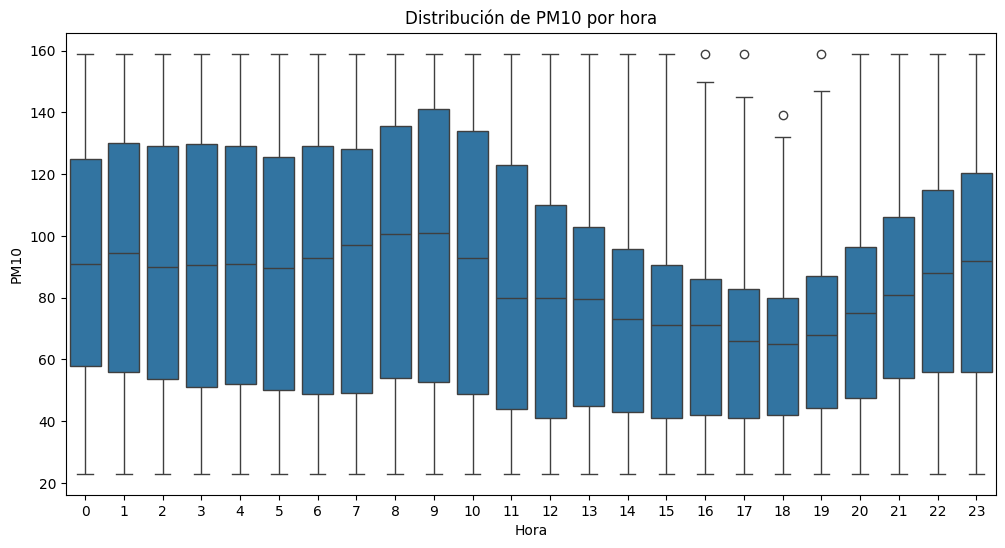

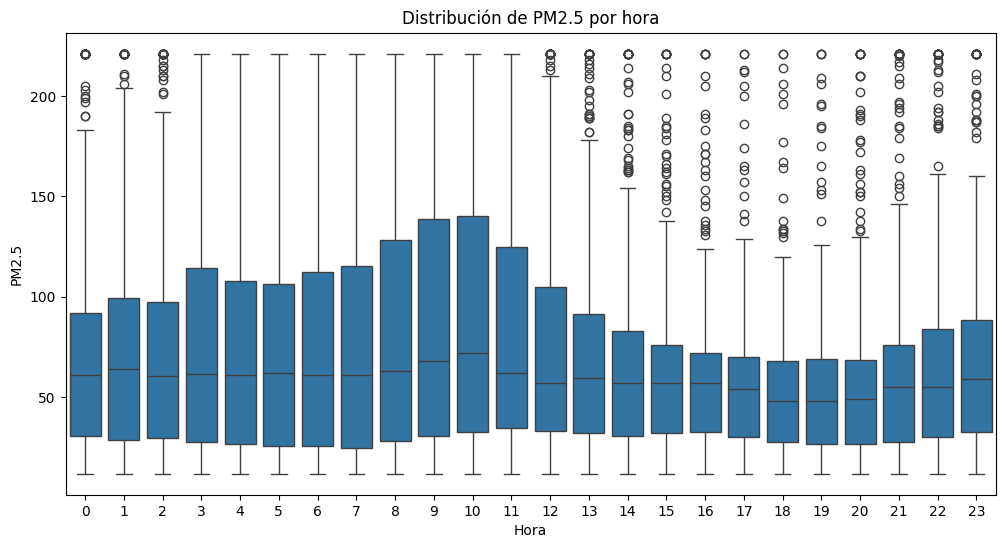

In [7]:
#La hora se convierte a formato datetime, para poder mostrar la distribución de pm10 y pm2.5 en diagramas de cajas y bigotes (boxplot)
df['Time'] = pd.to_datetime(df['Time'])

# Crear el boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Time'].dt.hour, y=df['PM10'], data=df)
plt.title('Distribución de PM10 por hora')
plt.xlabel('Hora')
plt.ylabel('PM10')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Time'].dt.hour, y=df['PM2.5'], data=df)
plt.title('Distribución de PM2.5 por hora')
plt.xlabel('Hora')
plt.ylabel('PM2.5')
plt.show()


*Tal como se observa, la winsorización no eliminó los outliers, sino que los llevó a que fueran valores menos extremos.*

In [8]:
#Descripción de los datos (se verifica especialmente la desviación estándar, std), para verificar numéricamente la distribución
df.describe().T

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


,count,mean,min,25%,50%,75%,max,std
Time,8010,2025-05-24 11:28:55.730336768,2025-05-24 00:00:00,2025-05-24 05:00:00,2025-05-24 11:00:00,2025-05-24 18:00:00,2025-05-24 23:00:00,NaN
PM10,8010.0,83.172534,23.0,48.0,80.0,114.0,159.0,40.205664
PM2.5,8010.0,72.886517,12.0,29.0,57.0,92.0,221.0,57.175694


#5. Codificación de características categóricas (categoría del AQI)

* Por medio de Pandas map() (un diccionario Python con las clasificaciones numéricas de cada categoría AQI) se crea una nueva columna (feature) llamada AQI_Category_Encoded.

* Necesario porque algunos modelos no entrenan con datos categóricos, sino numéricos (los de clasificación de sklearn, menos los árboles de decisión, entrenan únicamente con números).

* Se utiliza map, debido a que el diccionario tiene un orden similar al que daría OrdinalEncoder de sklearn (menor a mayor, de bueno a peligroso, respectivamente)

In [9]:
aqi_mapping = {
    "Bueno": 0,
    "Moderado": 1,
    "No sano para grupos sensitivos": 2,
    "No sano en general" : 3,
    "Muy poco sano": 4,
    "Peligroso": 5

    }

#Almacenamiento de la categoría en el df
df['AQI_Category_Encoded'] = df['AQI_Category'].map(aqi_mapping)

*Por medio de la librería joblib se da persistencia al encoder, que se llama aqi_mapping, para posteriormente ser utilizado en la conversión de resultados que da el modelo al predecir*

In [10]:
from joblib import dump, load


# Guarda el mapeo AQI en un archivo joblib, por medio del método dump()
dump(aqi_mapping, 'aqi_mapping.joblib')


['aqi_mapping.joblib']

In [11]:
#Se verifica la distribución del dataframe, con el nuevo feature de AQI_Category_Encoded
df

,Time,PM10,PM2.5,AQI_Category,AQI_Category_Encoded
0,2025-05-24 01:00:00,159.0,211.0,Muy poco sano,4
1,2025-05-24 02:00:00,159.0,221.0,Muy poco sano,4
2,2025-05-24 03:00:00,159.0,221.0,Muy poco sano,4
3,2025-05-24 04:00:00,159.0,221.0,Muy poco sano,4
4,2025-05-24 05:00:00,159.0,221.0,Muy poco sano,4
...,...,...,...,...,...
8005,2025-05-24 20:00:00,48.0,49.0,Bueno,0
8006,2025-05-24 21:00:00,51.0,43.0,Bueno,0
8007,2025-05-24 22:00:00,63.0,41.0,Bueno,0
8008,2025-05-24 23:00:00,70.0,42.0,Bueno,0


* Además de esto, se tuvo que codificar también la hora, debido a que se encuentra en formato datetime (un formato que no aceptan muchos modelos)

* Se almacenó el encoder (codificador) en un archivo joblib, por medio del método dump(); se realizó con un LabelEncoder de sklearn.

* Además, al notar que la columna AQI_Category ya no funciona para el modelo, se sobreescribe el dataframe y se elimina  (drop)

In [12]:

# Eliminar la columna 'AQI_Category'
df = df.drop(columns=['AQI_Category'])

# Renombrar la columna 'AQI_Category_Encoded' a 'AQI_Category'
df = df.rename(columns={'AQI_Category_Encoded': 'AQI_Category'})

# Codificar la hora
from sklearn.preprocessing import LabelEncoder

encoded_hour = LabelEncoder()
df['Time'] = encoded_hour.fit_transform(df['Time'])

# Guardar el codificador de horas
dump(encoded_hour, 'encoded_hour.joblib')
df


,Time,PM10,PM2.5,AQI_Category
0,1,159.0,211.0,4
1,2,159.0,221.0,4
2,3,159.0,221.0,4
3,4,159.0,221.0,4
4,5,159.0,221.0,4
...,...,...,...,...
8005,20,48.0,49.0,0
8006,21,51.0,43.0,0
8007,22,63.0,41.0,0
8008,23,70.0,42.0,0


* Anterior a la división de datos de prueba y entrenamiento, se debe realizar una observación de la distribución.

* Para ello, se utilizan las librerías de matplotlib, seaborn y pandas para conocer cómo se encuentra el conjunto de datos.

El siguiente código realiza esto:

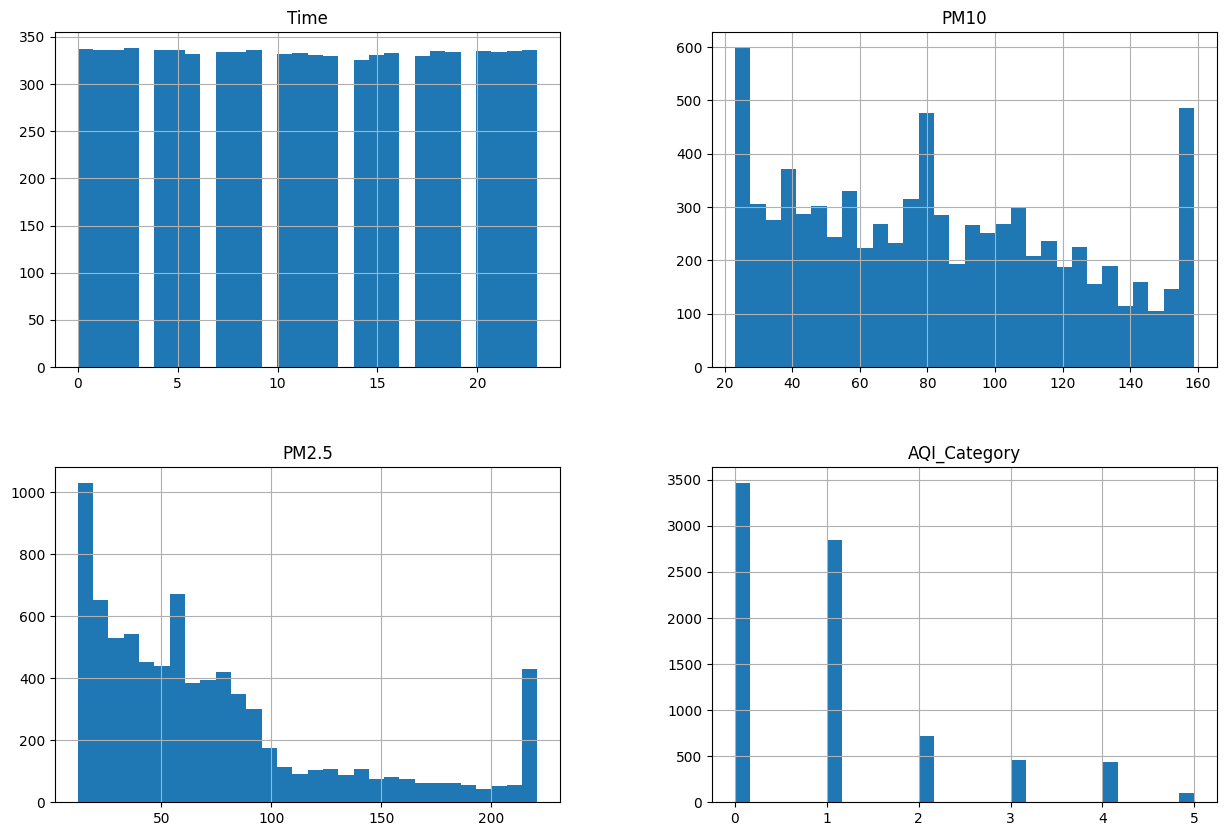

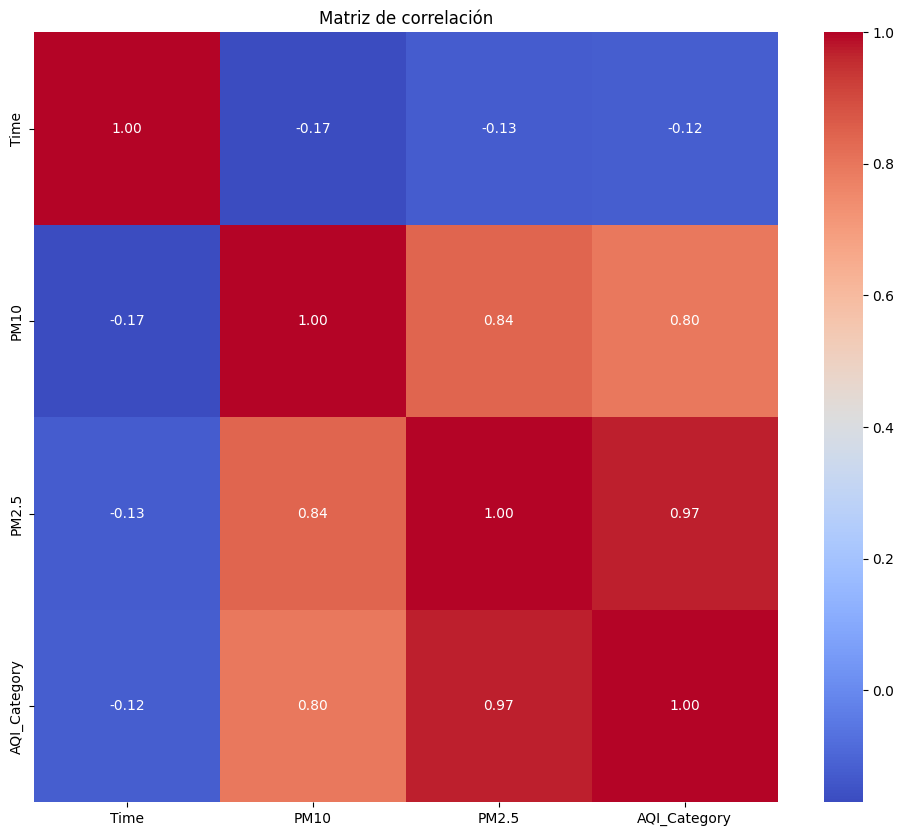

In [13]:
# Mostrar la distribución de las variables numéricas
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Mostrar la matriz de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

#6. Verificación del balanceo de clases categóricas

* Por medio de algunos gráficos realizados con Seaborn (sns) y Matplotlib (plt), se observa la cantidad de registros por categoría de aqi general (0,1,2,3,4,5).

* Es necesario, en caso de que se encuentren altamente desbalanceados, balancearlos por medio de alguna técnica como SMOTE, dado que el modelo podría tener "preferencias" por la clase mayoritaria.

Valores por categoría de AQI (0 a 5)
AQI_Category
0    3460
1    2842
2     715
3     457
4     440
5      96
Name: count, dtype: int64


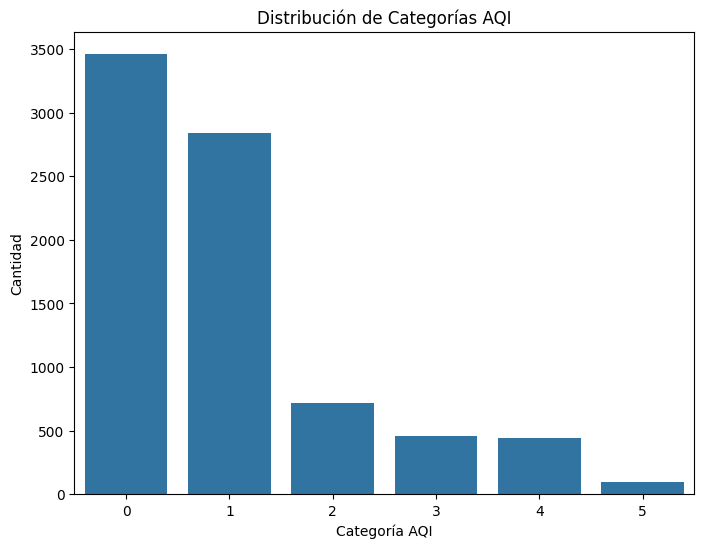

In [14]:
# Contar la cantidad de datos en cada categoría AQI
aqi_counts = df['AQI_Category'].value_counts()
print("Valores por categoría de AQI (0 a 5)")
print(aqi_counts)

# Gráfico de barras para visualizar la distribución de las categorías AQI, de manera más fácil
plt.figure(figsize=(8, 6))
sns.countplot(x='AQI_Category', data=df)
plt.title('Distribución de Categorías AQI')
plt.xlabel('Categoría AQI')
plt.ylabel('Cantidad')
plt.show()


*Tal como se observa, las clases están altamente desbalanceadas, por lo que se tiene que realizar un tratamiento, de los mencionados*

* Anterior a esto, por medio de joblib (método dump) se escalan (normalizan) los datos del dataframe, en una escala del 0 al 1, debido a que algunos modelos funcionan mejor así (los datos tienen que estar en una escala).

* Realizado por medio de MinMaxScaler, de Scikit-learn, debido a que el dataframe tiene características que dependen de otras, por lo que no se puede usar un StandardScaler (valores negativos).

* Se da persistencia al escalador por medio de joblib y se normalizan únicamente las características de PM2.5 y PM10, ya que el label no se normaliza.

In [15]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Crear el objeto scaler
scaler = MinMaxScaler()

# Normalizar las características numéricas
df[['PM2.5', 'PM10']] = scaler.fit_transform(df[['PM2.5', 'PM10']])

# Guardar el scaler en un archivo .joblib para usarlo posteriormente
joblib.dump(scaler, 'scaler3.joblib')

# Ver los primeros datos después de la normalización
df.head()

,Time,PM10,PM2.5,AQI_Category
0,1,1.0,0.952153,4
1,2,1.0,1.000000,4
2,3,1.0,1.000000,4
3,4,1.0,1.000000,4
4,5,1.0,1.000000,4


*Como se mencionó, se realiza un oversampling (sobremuestreo) de los datos por medio de SMOTE, dividiendo los datos para ajustarlos (fit)*

AQI_Category
4    3460
2    3460
1    3460
3    3460
5    3460
0    3460
Name: count, dtype: int64


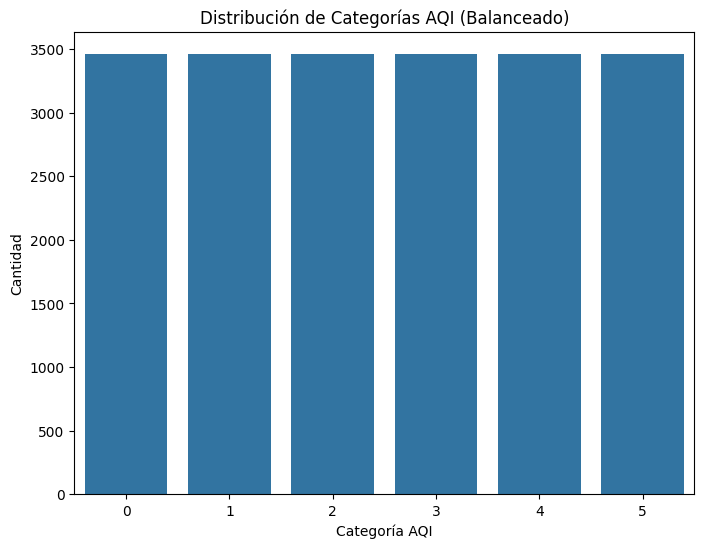

In [16]:
from imblearn.over_sampling import SMOTE

# Separar las características (X) de la variable objetivo (y)
X = df.drop('AQI_Category', axis=1)
y = df['AQI_Category']

# Aplicar SMOTE para el balanceo de clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['AQI_Category'] = y_resampled

# Verificar el balanceo de clases
aqi_counts = df_balanced['AQI_Category'].value_counts()
print(aqi_counts)

# Gráfico de barras para visualizar la distribución de las categorías AQI, ahora balanceadas
plt.figure(figsize=(8, 6))
sns.countplot(x='AQI_Category', data=df_balanced)
plt.title('Distribución de Categorías AQI (Balanceado)')
plt.xlabel('Categoría AQI')
plt.ylabel('Cantidad')
plt.show()


#Sobreescritura del df, ahora balanceado para el entrenamiento de modelos
df = df_balanced


#7. Evaluación de importancia de características (features)

* Por medio de Lasso (sklearn), se evalúa la importancia de los features (características), para conocer si son relevantes en cómo se realiza la predicción.

In [17]:
from sklearn.linear_model import Lasso

#Separación de X y y
X = df.drop('AQI_Category', axis=1)
y = df['AQI_Category']

#Declaración del modelo
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

#Obtención de la importancia de features
feature_importances = pd.Series(lasso.coef_, index=X.columns)


print(feature_importances)

#Verificación de la importancia de la hora
if abs(feature_importances['Time']) < 0.001:
  print("'Time' es poco importante.")
  df = df.drop(columns=['Time'])
  print("Dataframe sobreescrito")
else:
  print("'Time' es relativamente importante.")


Time    -0.001892
PM10     0.000000
PM2.5    4.661422
dtype: float64
'Time' es relativamente importante.


* Por tanto, se obtiene que el tiempo sí es relativamente importante en el análisis.

#8. Separación de caracrerísticas de prueba y entrenamiento y entrenamiento de modelos

* Por medio de las librerías que proporciona scikit-learn para dividir los datos y crear modelos, como train_test_split.

* Además, medición del accuracy (exactitud) de los modelos, para determinar el mejor (esto, temporalmente; luego se realizará la evaluación de los modelos con otras métricas como ROC, AUC, R^2, MAE, etc).

* Matriz de confusión para conocer los verdaderos y falsos (solo tiene estas 2, porque es multiclase, no binomial)

In [18]:
#Importación de librerías
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_squared_error, roc_curve, auc


# Separar las características (X) y la variable objetivo (y)
X = df[['Time', 'PM2.5', 'PM10']]
y = df['AQI_Category']

# Dividir los datos en conjuntos de entrenamiento y prueba (estratificación para clasificar datos en grupos más parecidos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (16608, 3)
Tamaño del conjunto de prueba: (4152, 3)


* Se siguen, principalmente estos pasos:
1. Se declara el modelo (en este caso, nb_model porque es un Naive Bayes multinomial, que funciona por medio de la probabilidad bayesiana).
2. Se ajustan los datos de entrenamiento (X_train y y_train) al modelo
3. Se predicen datos con la sección de prueba del dataframe (conjunto que nunca vio los datos), por medio del método predict().
4.Almacenamiento del modelo con el método .dump() de joblib.

In [20]:
# Crear el modelo Naive Bayes
nb_model = MultinomialNB()

# Entrenar el modelo
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = nb_model.predict(X_test)
joblib.dump(nb_model, 'nb_model.joblib')

['nb_model.joblib']

* Luego, se procede a calcular la accuracy (exactitud) del modelo, por medio de la matriz de confusión (en esta, se contemplan los verdaderos positivos, los verdaderos negativos, los falsos positivos y los falsos negativos)

In [21]:
# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy}")

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.37789017341040465
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       692
           1       0.36      0.44      0.39       692
           2       0.28      0.21      0.24       692
           3       0.27      0.17      0.21       692
           4       0.38      0.13      0.19       692
           5       0.29      0.60      0.39       692

    accuracy                           0.38      4152
   macro avg       0.39      0.38      0.36      4152
weighted avg       0.39      0.38      0.36      4152



In [22]:
from sklearn.svm import SVC

# Crear el modelo SVC
svc_model = SVC(kernel='linear', random_state=42)  # Puedes experimentar con diferentes kernels

# Entrenar el modelo
svc_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svc_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVC: {accuracy}")

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))
joblib.dump(svc_model, 'svc_model.joblib')


Precisión del modelo SVC: 0.8935452793834296
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       692
           1       0.96      0.99      0.97       692
           2       1.00      0.98      0.99       692
           3       0.98      1.00      0.99       692
           4       0.84      0.53      0.65       692
           5       0.66      0.90      0.76       692

    accuracy                           0.89      4152
   macro avg       0.90      0.89      0.89      4152
weighted avg       0.90      0.89      0.89      4152



['svc_model.joblib']

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=50)  # Puedes ajustar el número de vecinos

# Entrenar el modelo
knn_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo KNN: {accuracy}")

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))
joblib.dump(knn_model, 'knn_model.joblib')

Precisión del modelo KNN: 0.8535645472061657
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       692
           1       0.85      0.88      0.86       692
           2       0.93      0.92      0.92       692
           3       0.94      0.95      0.95       692
           4       0.82      0.60      0.70       692
           5       0.70      0.89      0.78       692

    accuracy                           0.85      4152
   macro avg       0.86      0.85      0.85      4152
weighted avg       0.86      0.85      0.85      4152



['knn_model.joblib']

In [24]:
print(y_pred)

[5 0 1 ... 5 1 4]


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=2, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
  # Puedes ajustar el número de árboles

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo Random Forest: {accuracy}")

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))
joblib.dump(rf_model, 'rf_model.joblib')


Precisión del modelo Random Forest: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       692
           1       0.98      0.96      0.97       692
           2       0.99      0.99      0.99       692
           3       0.99      0.99      0.99       692
           4       0.84      0.70      0.76       692
           5       0.74      0.87      0.80       692

    accuracy                           0.92      4152
   macro avg       0.92      0.92      0.92      4152
weighted avg       0.92      0.92      0.92      4152



['rf_model.joblib']

* Al ser el de mejor exactitud el Random Forest Clasiffier, se escoje este para predecir.

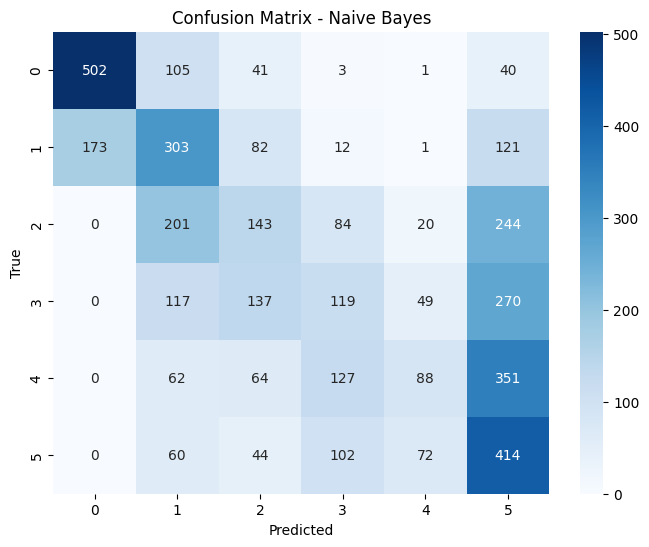

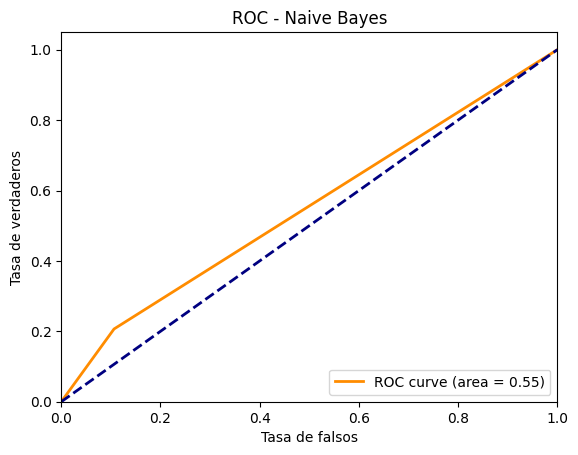

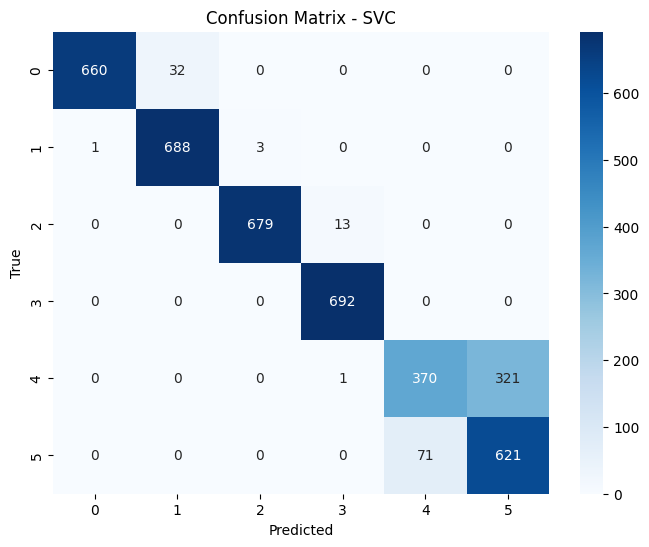

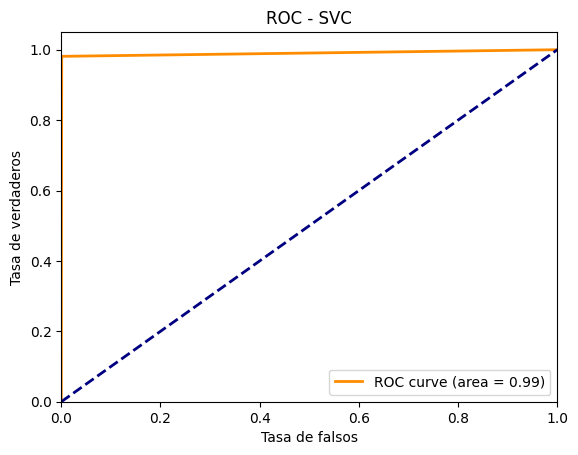

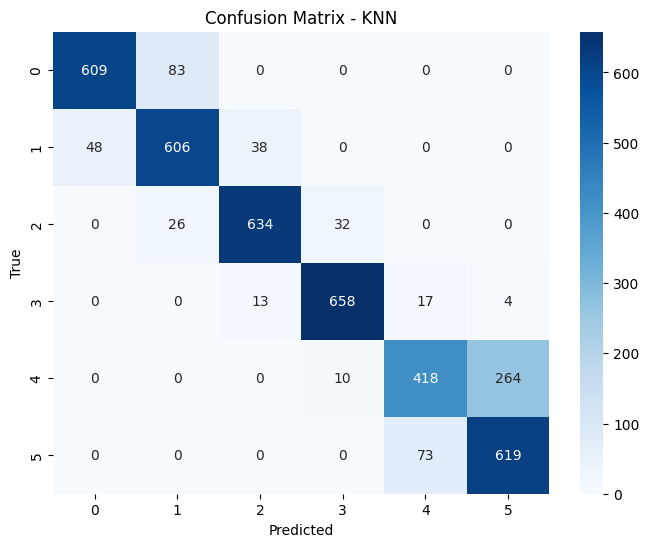

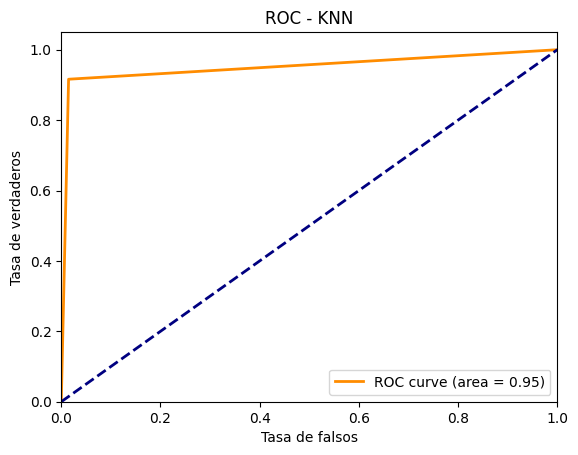

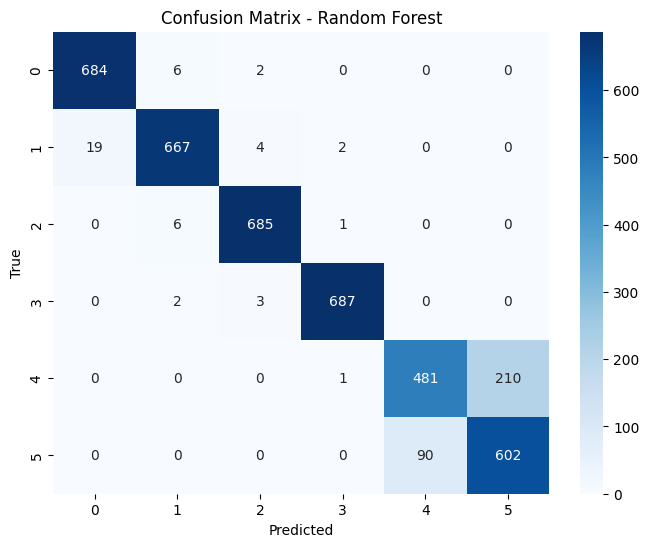

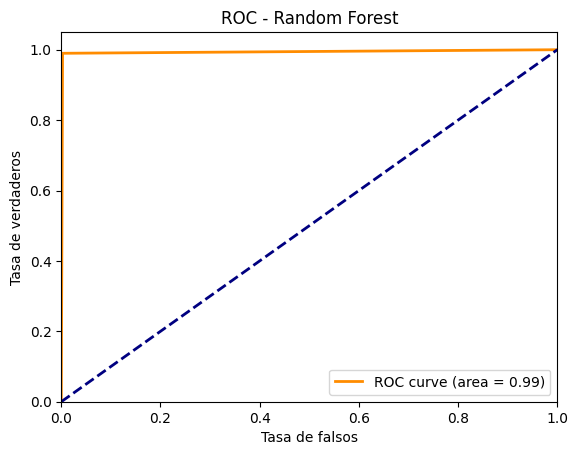

In [26]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the trained models
nb_model = joblib.load('nb_model.joblib')
svc_model = joblib.load('svc_model.joblib')
knn_model = joblib.load('knn_model.joblib')
rf_model = joblib.load('rf_model.joblib')

models = {
    "Naive Bayes": nb_model,
    "SVC": svc_model,
    "KNN": knn_model,
    "Random Forest": rf_model
}

for model_name, model in models.items():
  y_pred = model.predict(X_test)

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title(f"Confusion Matrix - {model_name}")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()


  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  from sklearn.multiclass import OneVsRestClassifier
  from sklearn.preprocessing import label_binarize

  y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
  y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

  for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


  plt.figure()
  lw = 2
  plt.plot(fpr[2], tpr[2], color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasa de falsos')
  plt.ylabel('Tasa de verdaderos')
  plt.title(f'ROC - {model_name}')
  plt.legend(loc="lower right")
  plt.show()


#9. Validación del funcionamiento del modelo

* Por medio de inputs de usuario simulados (datos que un usuario escogería, al azar, para la prueba) se prueba el output (salida) de predicción del modelo.

* Se realizó para validar, debido a que anteriormente un modelo tenía accuracy del "100%", aunque estaba muy sesgado hacia predecir la categoría 5; solo daba ese valor.

In [27]:
# Cargar el scaler
scaler = joblib.load('scaler3.joblib')

# Cargar el codificador de horas
encoded_hour = joblib.load('encoded_hour.joblib')

# Simular datos introducidos por el usuario
user_hour = 10  # Introducido por el usuario
user_pm25 = 370  # Introducido por el usuario
user_pm10 = 200  # Introducido por el usuario

# Preprocesar los datos del usuario
user_data_scaled = scaler.transform([[user_pm25, user_pm10]])
user_data = np.concatenate(([user_hour], user_data_scaled[0]), axis=0).reshape(1, -1)

# Realizar la predicción con el modelo KNN
prediction = knn_model.predict(user_data)

# Interpretar la predicción
aqi_mapping_loaded = load('aqi_mapping.joblib')
predicted_aqi_category = list(aqi_mapping_loaded.keys())[list(aqi_mapping_loaded.values()).index(prediction[0])]

print(f"La predicción de la categoría AQI es: {predicted_aqi_category}")


La predicción de la categoría AQI es: Peligroso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [28]:
# Cargar el scaler
scaler = joblib.load('scaler3.joblib')

# Cargar el codificador de horas
encoded_hour = joblib.load('encoded_hour.joblib')

# Simular datos introducidos por el usuario
user_hour = 1  # Introducido por el usuario
user_pm25 = 360  # Introducido por el usuario
user_pm10 = 200  # Introducido por el usuario

# Preprocesar los datos del usuario
user_data_scaled = scaler.transform([[user_pm25, user_pm10]])
user_data = np.concatenate(([user_hour], user_data_scaled[0]), axis=0).reshape(1, -1)

# Realizar la predicción con el modelo SVC
prediction = svc_model.predict(user_data)

# Interpretar la predicción
aqi_mapping_loaded = load('aqi_mapping.joblib')
predicted_aqi_category = list(aqi_mapping_loaded.keys())[list(aqi_mapping_loaded.values()).index(prediction[0])]

print(f"La predicción de la categoría AQI con SVC es: {predicted_aqi_category}")


La predicción de la categoría AQI con SVC es: Peligroso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [29]:
# Cargar el scaler
scaler = joblib.load('scaler3.joblib')

# Cargar el codificador de horas
encoded_hour = joblib.load('encoded_hour.joblib')

# Simular datos introducidos por el usuario
user_hour = 5  # Introducido por el usuario
user_pm25 = 500  # Introducido por el usuario
user_pm10 = 200  # Introducido por el usuario

# Preprocesar los datos del usuario
user_data_scaled = scaler.transform([[user_pm25, user_pm10]])
user_data = np.concatenate(([user_hour], user_data_scaled[0]), axis=0).reshape(1, -1)

# Realizar la predicción con el modelo SVC
prediction = rf_model.predict(user_data)

# Interpretar la predicción
aqi_mapping_loaded = load('aqi_mapping.joblib')
predicted_aqi_category = list(aqi_mapping_loaded.keys())[list(aqi_mapping_loaded.values()).index(prediction[0])]

print(f"La predicción de la categoría AQI con Random Forest es: {predicted_aqi_category}")

La predicción de la categoría AQI con Random Forest es: Muy poco sano


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#10. Escogimiento del mejor modelo, según las métricas de evaluación

* A partir de las métricas de Accuracy (exactitud), matriz de confusión (cantidad de verdaderos y falsos representados gráficamente, de la predicción), la curva ROC y el área bajo su curva (AUC), se determinó (temporalmente), el mejor modelo para predecir la categoría de la calidad de aire.

* El accuracy permite observar los aciertos de la predicción del modelo respecto al total de datos.

* La curva ROC funciona para clases más desbalanceadas, donde es mejor que utilizar únicamente el accuracy; debido a que las clases se encuentran balanceadas, se puede utilizar solo una métrica.


*Sin embargo, basándose tanto en el accuracy, curva roc y auc, el mejor modelo para predecir la categoría de calidad del aire es el de RandomForest (bosques aleatorios); su accuracy es la mayor (.92), además de que tiene un auc igual al SVC (.99), por lo que se escoje, por conveniencia estadística, este*.

**Es importante mencionar que se utilizaron, en los modelos (exceptuando Naive Bayes Multinomial), hiperparámetros arbitrarios; la inclusión de estos representaría una mejora significativa en el modelo, dado que se probarían con todas las combinaciones posibles de esto. Se realizará por medio de GridSearchCV, una validación cruzada de hiperparámetros.**

# 11. Optimización de hiperparámetros en modelos anteriormente entrenados

* Se utiliza GridSearch, una validación cruzada para probar con todos los hiperparámetros y encontrar la mejor combinación; esto es útil para lograr la máxima optimización posible del modelo.

* Inicialmente, se entrenarán modelos de K Nearest Neighbors Classifier y Random Forest Classifier.

* Luego, se probará con hiperparámetros en modelos de regresión, en vez de clasificación.

# 11.1 KNN (K Nearest Neighbors)

* Se utilizará, nuevamente, GridSearchCV para encontrar los mejores parámetros con el modelo KNeighborsClassifier

* Posteriormente, se entrenará el modelo con la mejor combinación de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

knn_c = KNeighborsClassifier()

param_grid_k = {
        'n_neighbors': np.arange(1,61),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
}

grid_search_knn = GridSearchCV(estimator=knn_c, param_grid=param_grid_k, cv=5, scoring = 'accuracy')
grid_search_knn.fit(X_train, y_train)

best_knn = grid_search_knn.best_estimator_
print("Mejores parámetros:", best_knn)

KeyboardInterrupt: 

*A continuación, se adjunta una imagen del resultado de ejecución de la celda anterior*

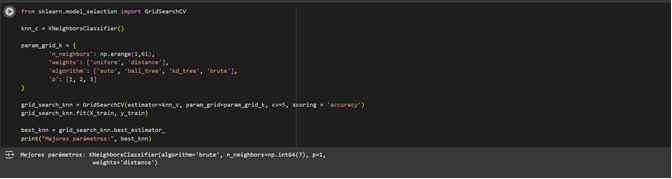

#11.2 RandomForest (Bosques aleatorios)

* Se utilizará, nuevamente, GridSearchCV para encontrar los mejores parámetros con el modelo RandomForestClassifier

* Posteriormente, se entrenará el modelo con la mejor combinación de hiperparámetros

In [ ]:
rf_c = RandomForestClassifier()

param_grid_r = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'criterion': ["gini", "entropy", "log_loss"]
}

grid_search_svc = GridSearchCV(estimator=rf_c, param_grid=param_grid_r, cv=5, scoring = 'accuracy')
grid_search_svc.fit(X_train, y_train)

best_rf = grid_search_svc.best_estimator_
print("Mejores parámetros:", best_rf)

*A continuación, se deja el resultado de ejecución de la celda anterior*
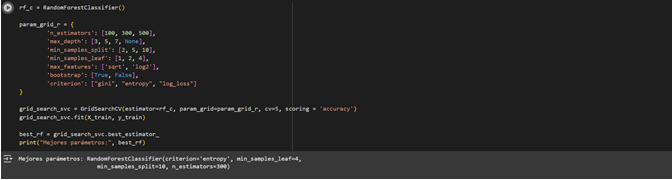

#12. Entrenamiento de XGBOOST

* Posteriormente al entrenamiento de modelos, se entrena un modelo XGBOOST (Extreme Gradiente Boosting), para compararlo con los demás modelos entrenados anteriormente (de clasificación).

* Además, se buscará la mayor optimización del modelo por medio de GridSearchCV, al igual que en los anteriores.

In [ ]:
#Importación de librerías
import xgboost as xgb


xgb_c = xgb.XGBClassifier()

param_grid_xgb = {
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

grid_search_xgb = GridSearchCV(estimator=xgb_c, param_grid=param_grid_xgb, cv=5, scoring = 'accuracy')
grid_search_xgb.fit(X_train, y_train)

best_xgbc = grid_search_xgb.best_estimator_
print("Mejores parámetros:", best_xgbc)

NameError: name 'GridSearchCV' is not defined

*A continuación, se adjunta la imagen con el resultado de la ejecución de la celda anterior*

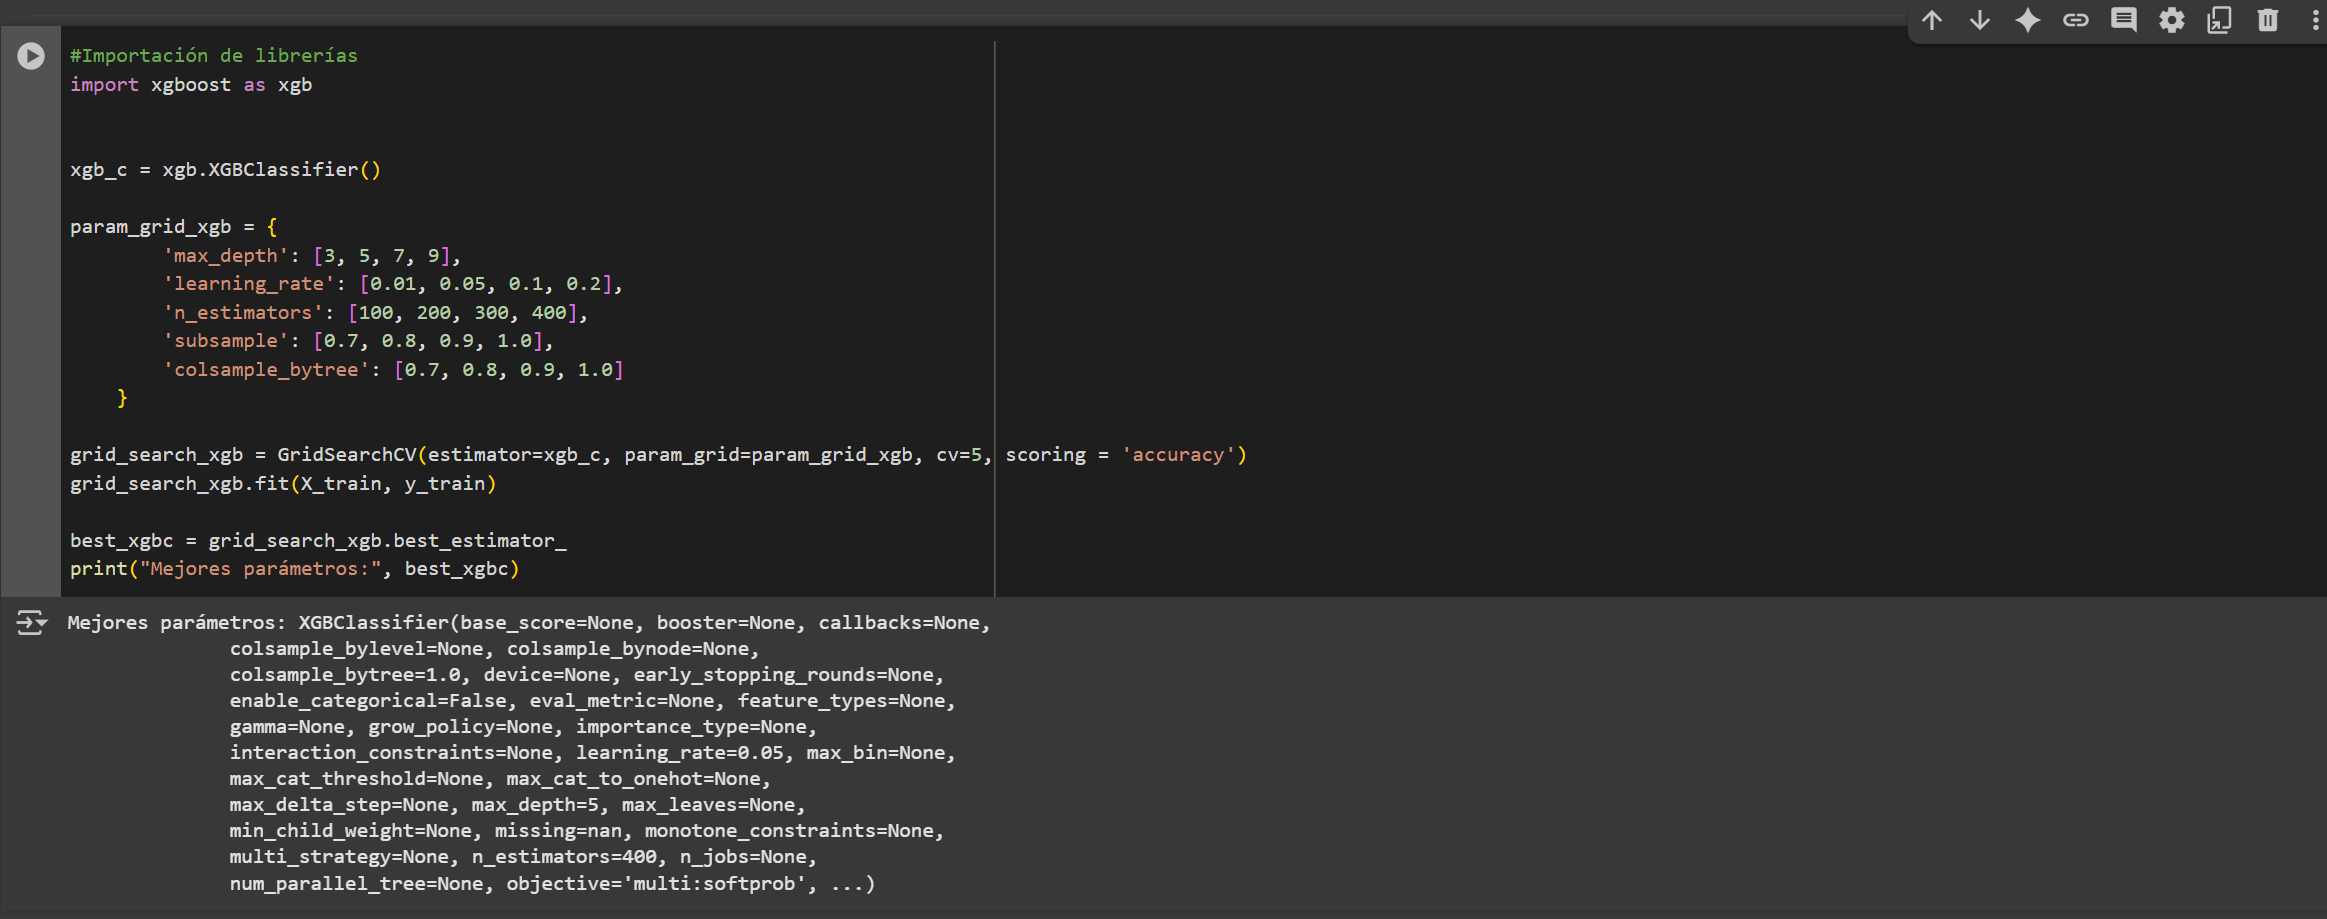

#13. Evaluación del rendimiento de modelos, con GridSearchCV

* Una vez se obtenidos los mejores hiperparámetros, se declaran los modelos por medio de estos (para más información de los hiperparámetros, ver las capturas de pantalla en las celdas anteriores).

* Los modelos son evaluados a través del accuracy (exactitud), ROC y área bajo la curva ROC (AUC); el mejor de ellos es el que tenga mejor accuracy y mejor AUC al mismo tiempo, a menos que tengan similares (en ese caso, una métrica define el escogimiento).

* Esto se realiza debido a que se prueban todas las posibilidades con diferentes parámetros, encontrando el mejor posible.

#13.1 KNN (KNeighborsClassifier)

In [ ]:
best_knn = KNeighborsClassifier(algorithm='brute', n_neighbors=7, p=1, weights='distance')
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=7, p=1, weights='distance')

In [ ]:
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo KNN: {accuracy}")

Exactitud del modelo KNN: 0.9140173410404624


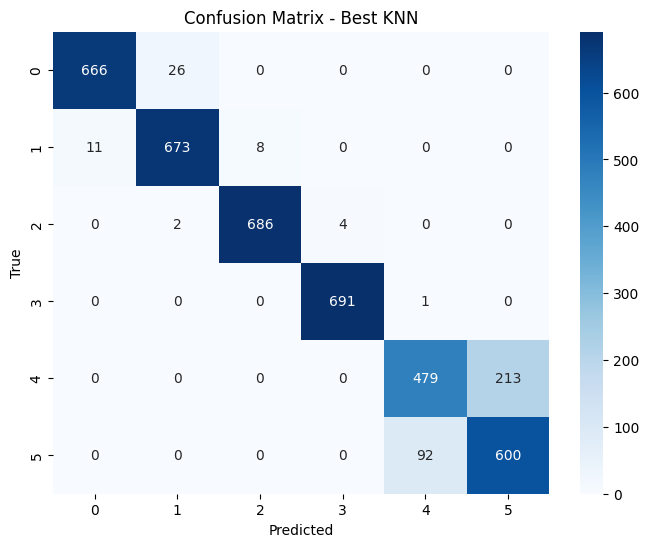

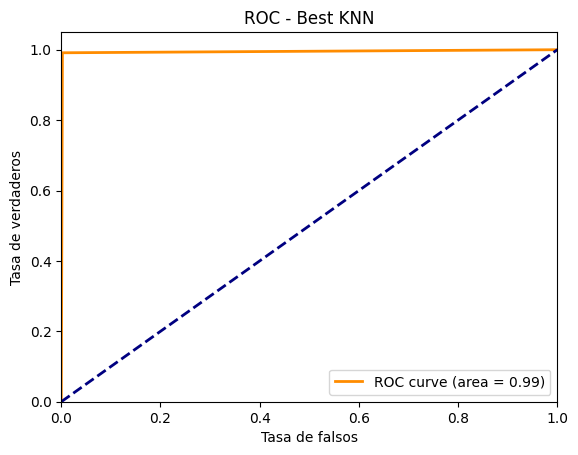

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix - Best KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


fpr = dict()
tpr = dict()
roc_auc = dict()


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

for i in range(y_test_bin.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos')
plt.ylabel('Tasa de verdaderos')
plt.title(f'ROC - Best KNN')
plt.legend(loc="lower right")
plt.show()


#13.2 RandomForestClassifier (bosques aleatorios)

In [31]:
best_random_forest = RandomForestClassifier(criterion='entropy',min_samples_leaf=4,min_samples_split=10,n_estimators=300)
best_random_forest.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=300)

In [ ]:
y_pred = best_random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo RandomForest: {accuracy}")

Exactitud del modelo RandomForest: 0.9328034682080925


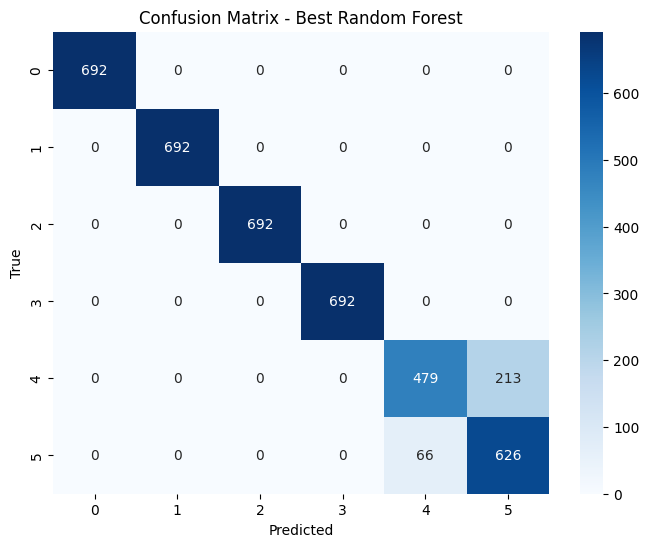

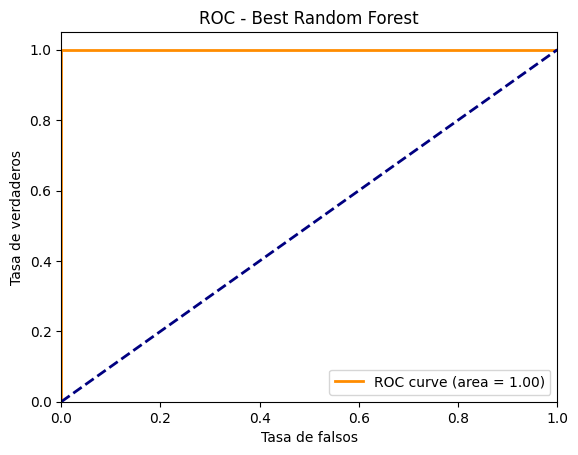

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix - Best Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


fpr = dict()
tpr = dict()
roc_auc = dict()


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

for i in range(y_test_bin.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos')
plt.ylabel('Tasa de verdaderos')
plt.title(f'ROC - Best Random Forest')
plt.legend(loc="lower right")
plt.show()


#13.3 XGBoost (XGBClassifier)

In [ ]:
best_xgbc_c = xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=400, colsample_bytree=1.0)
best_xgbc_c.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = best_xgbc_c.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo XGBoost de clasificación: {accuracy}")

Exactitud del modelo XGBoost de clasificación: 0.9313583815028902


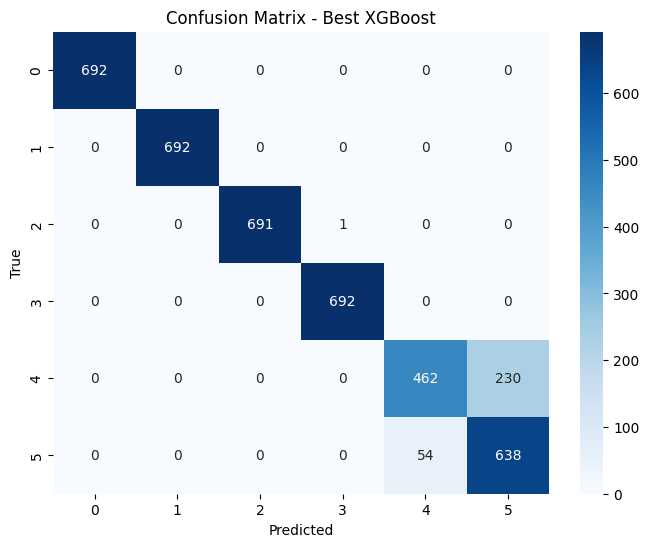

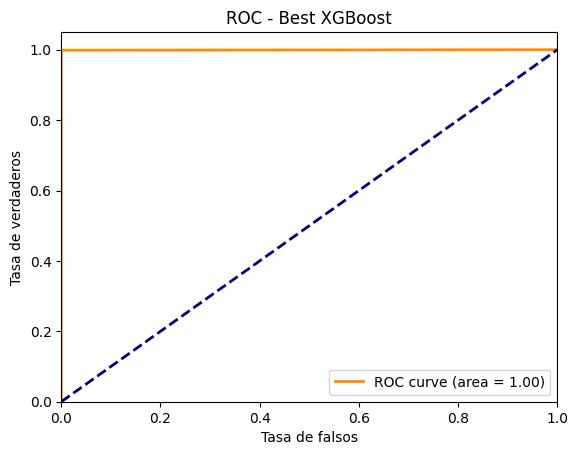

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix - Best XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


fpr = dict()
tpr = dict()
roc_auc = dict()


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

for i in range(y_test_bin.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos')
plt.ylabel('Tasa de verdaderos')
plt.title(f'ROC - Best XGBoost')
plt.legend(loc="lower right")
plt.show()


#Conclusión:

El modelo de clasificación más optimizado fue el Random Forest Classifier (optimizado con GridSearch para mayor rendimiento); debido a que sus ROC y AUC son idénticos, se definió por medio de la matriz de confusión el que se elige. En este caso, el XGBoost poseía 3867 aciertos y 285 desaciertos, mientras que el RFC (RandomForestClassifier) poseía 3873 aciertos y 279 desaciertos; de acuerdo a esto, es ligeramente mejor el RandomForest, por lo cual se da persistencia a este, para utilizarlo en el despliegue (deployment) hacia el backend (render).

#Persistencia al modelo best_rf

*De acuerdo a lo anteriormente explicado, se dará persistencia, por medio de joblib al modelo de RandomForestClassifier*

In [ ]:
joblib.dump(best_random_forest, 'best_rf.joblib')

['best_rf.joblib']